Step 1: Simulating the oscillatory response of the pyramidal neuron using the Jansen-Rit model

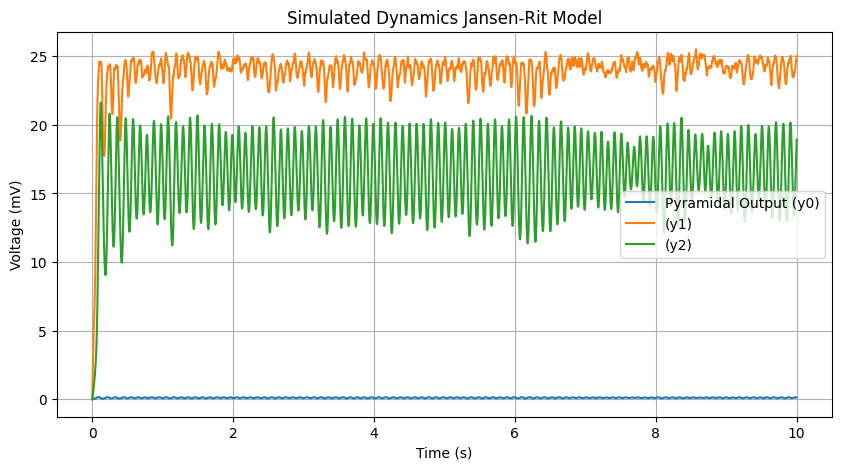

In [ ]:
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt

# Define parameters
A, B = 3.25, 22.0  # Amplitudes for excitatory and inhibitory populations
a, b = 100.0, 50.0  # Reciprocal time constants
e0, r, V0 = 2.5, 0.56, 6.0  # Sigmoid parameters
J = 135 # Average numbers of synapses between neural populations
J1, J2, J3, J4 = 1.0*J, 0.8*J, 0.25*J, 0.25*J # Synaptic gains

# Define simulation parameters
dt = 0.001  # Time step
duration = 10  # Simulation duration in seconds

def generate_external_input(key, size):
    # Uniformly distributed noise as external input
    return random.uniform(key, shape=(size,), minval=120.0, maxval=320.0)

# Sigmoid function
def sigmoid(V, V0=V0, e0=e0, r=r):
    return 2 * e0 / (1 + jnp.exp(r * (V0 - V)))

# Jansen-Rit equations
@jit
def jansen_rit_step(state, external_input):
    y0, y3, y1, y4, y2, y5 = state

    # y0 and y3 (pyramidal neuron populations)
    dy0 = y3
    dy3 = A * a * sigmoid(y1 - y2) - 2 * a * y3 - (a**2) * y0

    # y1 and y4 (excitatory populations)
    dy1 = y4
    dy4 = A * a * (external_input + J2 * sigmoid(J1 * y0)) - 2 * a * y4 - (a**2) * y1

    # y2 and y5 (inhibitory populations)
    dy2 = y5
    dy5 = B * b * J4 * sigmoid(J3 * y0) - 2 * b * y5 - (b**2) * y2

    # Return updated state
    return (
        y0 + dy0 * dt,
        y3 + dy3 * dt,
        y1 + dy1 * dt,
        y4 + dy4 * dt,
        y2 + dy2 * dt,
        y5 + dy5 * dt,
    )

# Initial state
y0, y3, y1, y4, y2, y5 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
state = (y0, y3, y1, y4, y2, y5)

# Time vector and output storage
t = jnp.arange(0, duration, dt)
key = random.PRNGKey(42)
external_input = generate_external_input(key, len(t))
trajectory_y0 = []
trajectory = []

# Simulate dynamics
for i in range(len(t)):
    state = jansen_rit_step(state, external_input[i])
    trajectory.append(state)
    trajectory_y0.append(state[0])  # Track y0 (pyramidal output)

trajectory = jnp.array(trajectory)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, trajectory[:,0], label="Pyramidal Output (y0)")
plt.plot(t, trajectory[:,2], label="(y1)")
plt.plot(t, trajectory[:,4], label="(y2)")
plt.title("Simulated Dynamics Jansen-Rit Model")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.grid()
plt.show()


Step 2: Training Autoencoder in PyTorch (full observability)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [ ]:
# Preparing the Training Data
# Convert Numpy array to PyTorch tensor, with data normalisation
raw_data = np.array(trajectory)
mean = np.mean(raw_data, axis=0)  # Compute mean for each state
std = np.std(raw_data, axis=0)    # Compute standard deviation for each state
normalised_data = (raw_data - mean) / std
data = normalised_data

# Create TensorDataset and DataLoader
data_tensor = torch.tensor(data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
print(f"Data tensor shape: {data_tensor.shape}")  # (num_timesteps, num_states)

Data tensor shape: torch.Size([10000, 6])


In [ ]:
# Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Latent representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 6)  # Reconstruct all state variables
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [ ]:
# Define the custom loss function with explicit observed indices
# Note: originially I wanted to take latent/unobserved state variables
# into account when computing the loss, but did not manage with it
# in the end. Thus some loss-func variables of the latent states were
# retained without actually being used.
def loss_func(reconstructed, target, observed_indices, latent_indices,
                         weight_observed=1.0, weight_latent=0.5):
    """
    Custom loss for the autoencoder with explicit index mapping (method: MSE)
    Args:
        reconstructed: Tensor of shape (batch_size, output_dim), predicted output (all states).
        target: Tensor of shape (batch_size, output_dim), ground truth states (all states).
        observed_indices: List of indices for observed states in the output.
        latent_indices: List of indices for latent states in the output (not used).
        weight_observed: Float, weight for the observed dimensions.
        weight_latent: Float, weight for the latent dimensions (not used).
    Return:
        loss: Computed loss value.
    """
    # Extract observed dimensions based on indices
    observed_reconstructed = reconstructed[:, observed_indices]
    observed_target = target

    # Compute MSE for observed and latent states separately
    observed_loss = nn.MSELoss()(observed_reconstructed, observed_target)

    # Combine losses with weights
    total_loss = weight_observed * observed_loss
    return total_loss

In [ ]:
# Hyperparameters
input_dim = 6  # Number of latent states in the NMM (e.g., 6 states: pyramidal, interneurons, etc.)
latent_dim = 3  # Dimensionality of the latent representation
batch_size = 32
learning_rate = 0.001
epochs = 50

# Initialize Autoencoder
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Specify indices for observed and latent states
observed_indices = [0, 1, 2, 3, 4, 5]  # Dimensions for observed states (all)
latent_indices = []   # Dimensions for latent states (none here)

# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in data_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Forward pass
        #loss = criterion(outputs, inputs)  # Reconstruction loss
        loss = loss_func(outputs, inputs, observed_indices, latent_indices,
                             weight_observed=1.0, weight_latent=0.5)
        #optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "autoencoder_nmm_fullobs.pth")


Epoch 1/50, Loss: 0.1287
Epoch 2/50, Loss: 0.0085
Epoch 3/50, Loss: 0.0076
Epoch 4/50, Loss: 0.0081
Epoch 5/50, Loss: 0.0064
Epoch 6/50, Loss: 0.0067
Epoch 7/50, Loss: 0.0075
Epoch 8/50, Loss: 0.0074
Epoch 9/50, Loss: 0.0065
Epoch 10/50, Loss: 0.0068
Epoch 11/50, Loss: 0.0062
Epoch 12/50, Loss: 0.0062
Epoch 13/50, Loss: 0.0091
Epoch 14/50, Loss: 0.0065
Epoch 15/50, Loss: 0.0064
Epoch 16/50, Loss: 0.0058
Epoch 17/50, Loss: 0.0062
Epoch 18/50, Loss: 0.0077
Epoch 19/50, Loss: 0.0061
Epoch 20/50, Loss: 0.0067
Epoch 21/50, Loss: 0.0069
Epoch 22/50, Loss: 0.0063
Epoch 23/50, Loss: 0.0059
Epoch 24/50, Loss: 0.0091
Epoch 25/50, Loss: 0.0064
Epoch 26/50, Loss: 0.0057
Epoch 27/50, Loss: 0.0056
Epoch 28/50, Loss: 0.0057
Epoch 29/50, Loss: 0.0060
Epoch 30/50, Loss: 0.0056
Epoch 31/50, Loss: 0.0087
Epoch 32/50, Loss: 0.0056
Epoch 33/50, Loss: 0.0055
Epoch 34/50, Loss: 0.0055
Epoch 35/50, Loss: 0.0060
Epoch 36/50, Loss: 0.0066
Epoch 37/50, Loss: 0.0071
Epoch 38/50, Loss: 0.0055
Epoch 39/50, Loss: 0.

Step 3: Training Autoencoder with partial observability

3.1 Observable states: membrane potentials of pyramidal, excitatory, and inhibitory neurons

In [ ]:
# Train the auto-encoder with membrane potentials of three cell types

# Data Prep
# Convert Numpy array to PyTorch tensor
data_tensor = torch.tensor(data[:,0:5:2], dtype=torch.float32)
# Create TensorDataset and DataLoader
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Hyperparameters
input_dim = 3  # Number of latent states in the NMM (here only 3 membrane potential states)
latent_dim = 3  # Dimensionality of the latent representation
batch_size = 32
learning_rate = 0.001
epochs = 50

# Initialize Autoencoder
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Specify indices for observed and latent states
observed_indices = [0, 2, 4]  # Dimensions for reconstructed membrane potentials (observed)
latent_indices = [1, 3, 5]   # Dimensions for reconstructed changing rate (latent)

# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in data_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = loss_func(outputs, inputs, observed_indices, latent_indices,
                             weight_observed=1.0, weight_latent=0.5)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "autoencoder_nmm_obs_potentials.pth")

Epoch 1/50, Loss: 0.0815
Epoch 2/50, Loss: 0.0017
Epoch 3/50, Loss: 0.0006
Epoch 4/50, Loss: 0.0035
Epoch 5/50, Loss: 0.0004
Epoch 6/50, Loss: 0.0044
Epoch 7/50, Loss: 0.0005
Epoch 8/50, Loss: 0.0001
Epoch 9/50, Loss: 0.0026
Epoch 10/50, Loss: 0.0009
Epoch 11/50, Loss: 0.0014
Epoch 12/50, Loss: 0.0004
Epoch 13/50, Loss: 0.0056
Epoch 14/50, Loss: 0.0013
Epoch 15/50, Loss: 0.0002
Epoch 16/50, Loss: 0.0084
Epoch 17/50, Loss: 0.0002
Epoch 18/50, Loss: 0.0002
Epoch 19/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0002
Epoch 21/50, Loss: 0.0006
Epoch 22/50, Loss: 0.0007
Epoch 23/50, Loss: 0.0021
Epoch 24/50, Loss: 0.0011
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0005
Epoch 27/50, Loss: 0.0006
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0006
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0001
Epoch 32/50, Loss: 0.0018
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0006
Epoch 35/50, Loss: 0.0002
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0001
Epoch 38/50, Loss: 0.0009
Epoch 39/50, Loss: 0.

3.2 Observable states: only membrane potentials of pyramidal neurons

In [ ]:
# Train the auto-encoder with membrane potential of pyramidal cells only

# Data Prep
# Convert Numpy array to PyTorch tensor
data_tensor = torch.tensor(data[:,0], dtype=torch.float32)
# Create TensorDataset and DataLoader
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Hyperparameters
input_dim = 1  # Number of latent states in the NMM (here only 1 state: pyramidal potential)
latent_dim = 3  # Dimensionality of the latent representation
batch_size = 32
learning_rate = 0.001
epochs = 50

# Initialize Autoencoder
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Specify indices for observed and latent states
observed_indices = [0,]  # Dimensions for reconstructed membrane pyramidal potentials (observed)
latent_indices = [1, 2, 3, 4, 5]   # Dimensions for latent states

# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in data_loader:
        inputs = batch[0]
        inputs = inputs.view(-1, 1) # Transpose the inputs as there is only one input neuron here
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = loss_func(outputs, inputs, observed_indices, latent_indices,
                             weight_observed=1.0, weight_latent=0.5)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "autoencoder_nmm_obs_pyramidal.pth")

Epoch 1/50, Loss: 0.0393
Epoch 2/50, Loss: 0.0000
Epoch 3/50, Loss: 0.0000
Epoch 4/50, Loss: 0.0000
Epoch 5/50, Loss: 0.0000
Epoch 6/50, Loss: 0.0000
Epoch 7/50, Loss: 0.0001
Epoch 8/50, Loss: 0.0000
Epoch 9/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0002
Epoch 11/50, Loss: 0.0000
Epoch 12/50, Loss: 0.0000
Epoch 13/50, Loss: 0.0000
Epoch 14/50, Loss: 0.0001
Epoch 15/50, Loss: 0.0009
Epoch 16/50, Loss: 0.0000
Epoch 17/50, Loss: 0.0000
Epoch 18/50, Loss: 0.0000
Epoch 19/50, Loss: 0.0000
Epoch 20/50, Loss: 0.0000
Epoch 21/50, Loss: 0.0000
Epoch 22/50, Loss: 0.0000
Epoch 23/50, Loss: 0.0002
Epoch 24/50, Loss: 0.0000
Epoch 25/50, Loss: 0.0000
Epoch 26/50, Loss: 0.0000
Epoch 27/50, Loss: 0.0001
Epoch 28/50, Loss: 0.0000
Epoch 29/50, Loss: 0.0000
Epoch 30/50, Loss: 0.0002
Epoch 31/50, Loss: 0.0000
Epoch 32/50, Loss: 0.0000
Epoch 33/50, Loss: 0.0000
Epoch 34/50, Loss: 0.0000
Epoch 35/50, Loss: 0.0001
Epoch 36/50, Loss: 0.0000
Epoch 37/50, Loss: 0.0001
Epoch 38/50, Loss: 0.0001
Epoch 39/50, Loss: 0.

Step 4: Plotting Autoencoder Reconstruction against Actual Data

In [ ]:
# Data Prep for Plotting: reconstructed data
# 1. Load the trained models one by one
# 2. For each model, prepare the reconstructed data (and save separately)
models = ["autoencoder_nmm_fullobs.pth","autoencoder_nmm_obs_potentials.pth",
          "autoencoder_nmm_obs_pyramidal.pth"]
dims = [[6,3],[3,3],[1,3]] # [input_dim,latent_dim]
observed_indices = [[0,1,2,3,4,5],[0,2,4],[0,]] # indices of observed states

model_reconstructed = []
model_latent = []
for ind in range(len(models)):
  # Load the trained model
  model = Autoencoder(input_dim=dims[ind][0], latent_dim=dims[ind][1])
  model.load_state_dict(torch.load(models[ind]))
  model.eval()  # Set the model to evaluation mode
  # Prepare the test data
  data_tensor = torch.tensor(data[:,observed_indices[ind]], dtype=torch.float32)
  test_data = data_tensor
  # Get reconstructed states
  with torch.no_grad():  # Disable gradient computation for evaluation
      reconstructed, latent = model(test_data)
      reconstructed_denormalized = reconstructed * std + mean
      reconstructed = reconstructed_denormalized
  # Convert tensors to NumPy arrays for plotting
  reconstructed_states = reconstructed.numpy()
  latent_states = latent.numpy()
  model_reconstructed.append(reconstructed_states)
  model_latent.append(latent_states)


<ipython-input-32-31e94aa7d1e2>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(models[ind]))


4.1 Raw Reconstructed Data

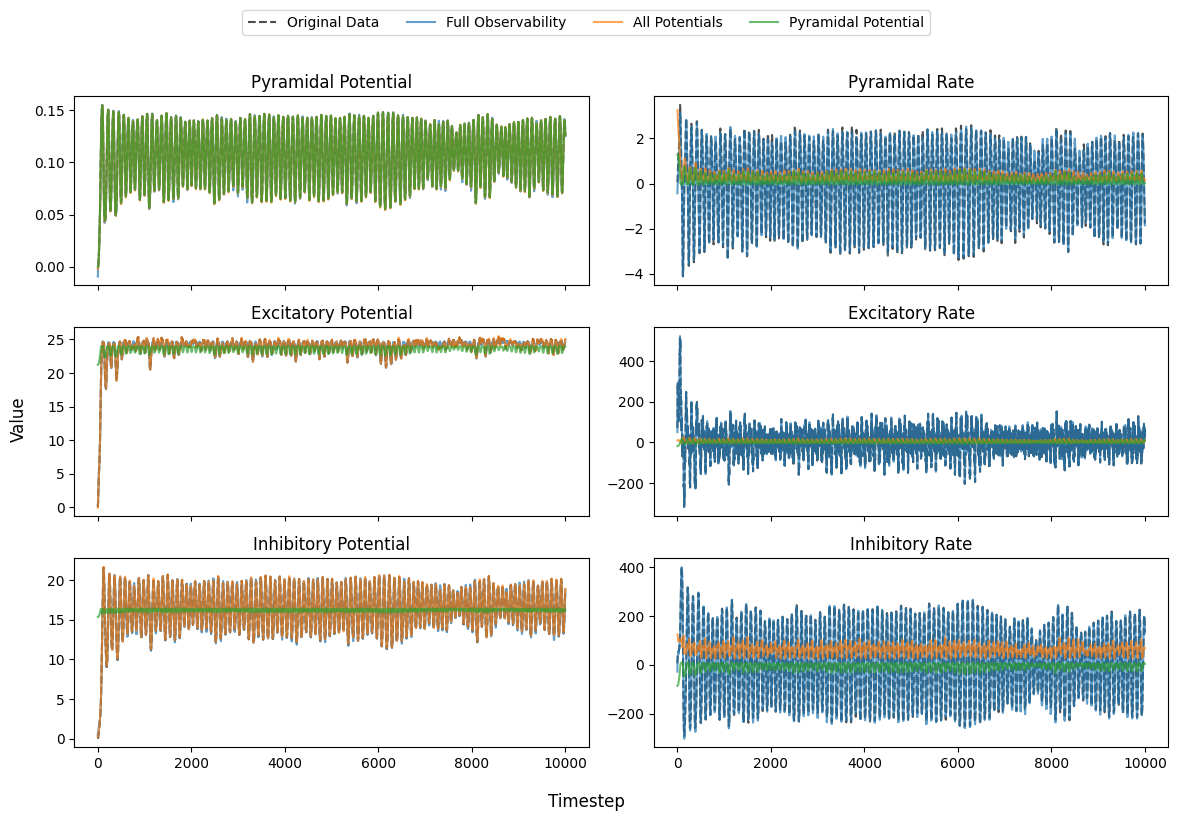

In [ ]:
# Plotting
# Actual data: raw_data variable
# Reconstructed data per model

# Correspond indices of states to their names
states_dict = {0: 'Pyramidal Potential', 2: 'Excitatory Potential', 4: 'Inhibitory Potential',
               1: 'Pyramidal Rate', 3: 'Excitatory Rate', 5: 'Inhibitory Rate'}

num_states = len(states_dict)  # Number of states (6 for each trained model)
labels = ["Full Observability", "All Potentials", "Pyramidal Potential"]

# Create a 3x2 figure layout with shared axes
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

axes = axes.flatten()

# For each state, plot the actual data and reconstructed data
for i, ax in enumerate(axes):
    # Plot actual data
    ax.plot(raw_data[:, i], label="Original Data", linestyle="--", alpha=0.7, color='black')
    # Plot reconstructed data for each model
    for ind in range(len(models)):
        reconstructed_states = model_reconstructed[ind]  # Reconstructed data from each model
        ax.plot(reconstructed_states[:, i], label=labels[ind], linestyle='-', alpha=0.7)

    ax.set_title(f'{states_dict[i]}')

fig.legend(labels=["Original Data"] + labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))
fig.supxlabel("Timestep")
fig.supylabel("Value")
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Save the fig
plt.savefig("reconstructed_raw.png", dpi=300, bbox_inches='tight')
plt.show()

4.2 Reconstruction Accuracy

In [ ]:
# Compute Reconstruction Accuracies
from scipy.stats import pearsonr

# Store correlations per model and per state variable
correlations_per_model = []

for model_idx, reconstructed_states in enumerate(model_reconstructed):
    state_correlations = []  # Correlations for each state variable

    for state_idx in range(raw_data.shape[1]):
        # True and reconstructed data
        true_values = raw_data[:, state_idx]
        reconstructed_values = reconstructed_states[:, state_idx]

        # Compute Pearson correlation over the entire time series
        corr, _ = pearsonr(true_values, reconstructed_values)
        corr = max(0,corr) # If corr is negative, then it means low accuracy
        state_correlations.append(corr)

    correlations_per_model.append(state_correlations)

# Results
for model_idx, state_corrs in enumerate(correlations_per_model):
    print(f"Model {model_idx + 1}:")
    for state_idx, corr in enumerate(state_corrs):
        print(f"  State {state_idx + 1}: Pearson Correlation = {corr:.4f}")

Model 1:
  State 1: Pearson Correlation = 0.9992
  State 2: Pearson Correlation = 0.9979
  State 3: Pearson Correlation = 0.9899
  State 4: Pearson Correlation = 0.9998
  State 5: Pearson Correlation = 0.9983
  State 6: Pearson Correlation = 0.9993
Model 2:
  State 1: Pearson Correlation = 0.9999
  State 2: Pearson Correlation = 0.0000
  State 3: Pearson Correlation = 0.9999
  State 4: Pearson Correlation = 0.0000
  State 5: Pearson Correlation = 0.9999
  State 6: Pearson Correlation = 0.3343
Model 3:
  State 1: Pearson Correlation = 1.0000
  State 2: Pearson Correlation = 0.0442
  State 3: Pearson Correlation = 0.4622
  State 4: Pearson Correlation = 0.3127
  State 5: Pearson Correlation = 0.1312
  State 6: Pearson Correlation = 0.8512


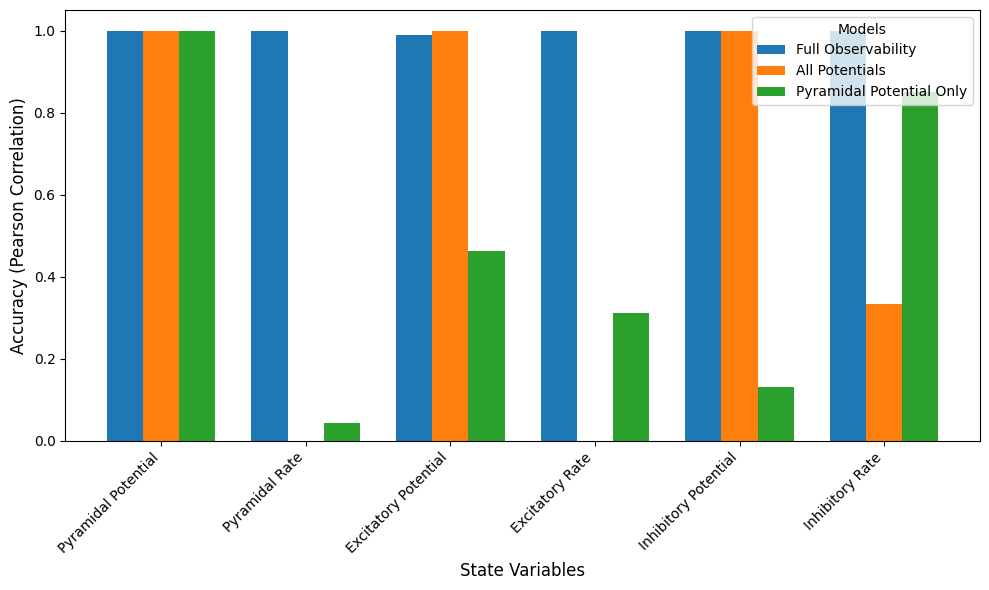

In [ ]:
# Plotting the accuracy values
# x-axis: each state variable
# legend: model (full, all potentials, pyramidal potentials)
# y-axis: accuracy
models = ["Full Observability", "All Potentials", "Pyramidal Potential Only"]
states = ["Pyramidal Potential", "Pyramidal Rate", "Excitatory Potential",
          "Excitatory Rate", "Inhibitory Potential", "Inhibitory Rate"]
correlations = np.array(correlations_per_model)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(states))  # x-axis positions for states
width = 0.25 # bar width

for i, model in enumerate(models):
    ax.bar(x + i * width, correlations[i], width, label=model)

ax.set_xlabel("State Variables", fontsize=12)
ax.set_ylabel("Accuracy (Pearson Correlation)", fontsize=12)
#ax.set_title("Reconstruction Accuracy", fontsize=14)
ax.set_xticks(x + width)  # Center x-ticks for grouped bars
ax.set_xticklabels(states, rotation=45, ha='right', fontsize=10)
ax.legend(title="Models", fontsize=10)

plt.tight_layout()
plt.savefig("accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

4.3 Latent Space of the Autoencoder

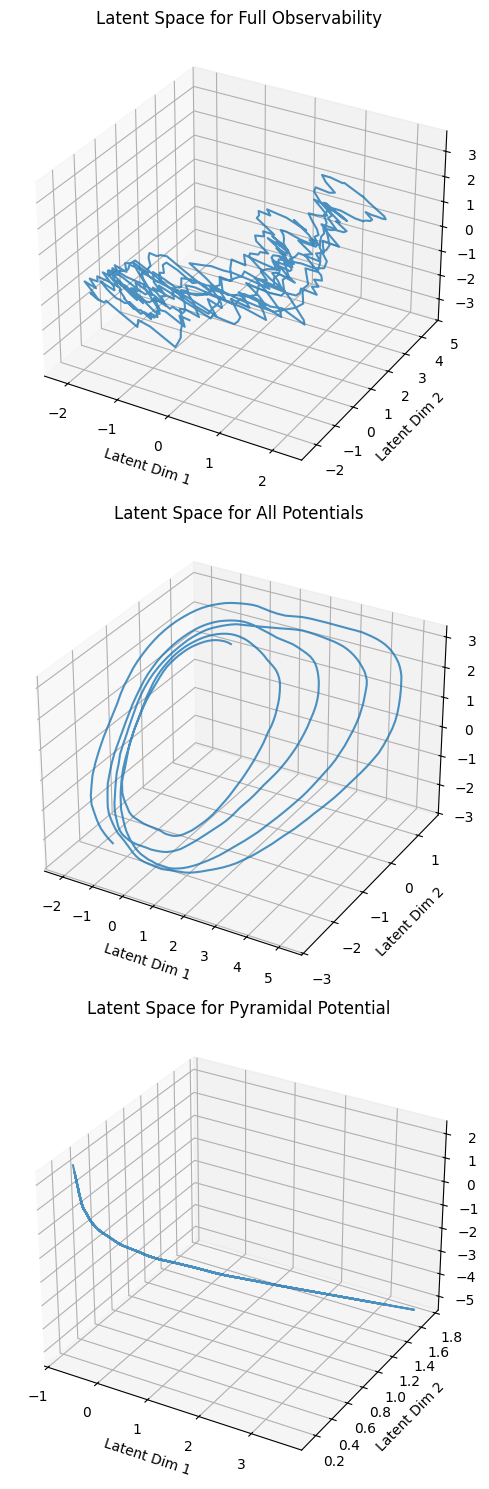

In [ ]:
# Plot latent space of each trained model in the autoencoder
from mpl_toolkits.mplot3d import Axes3D

labels = ["Full Observability", "All Potentials", "Pyramidal Potential"]
# Select a range of data points
start, end = 100, 600
sampled_latent_states_list = [latent[start:end] for latent in model_latent]

# Plotting: a vertically arranged figure with 3D subplots
fig = plt.figure(figsize=(8, len(sampled_latent_states_list) * 5))

for i, sampled_latent_states in enumerate(sampled_latent_states_list):
    ax = fig.add_subplot(len(sampled_latent_states_list), 1, i + 1, projection='3d')
    ax.plot(sampled_latent_states[:, 0],
            sampled_latent_states[:, 1],
            sampled_latent_states[:, 2],
            #c='blue',
            alpha=0.8)

    ax.set_title(f"Latent Space for {labels[i]}")
    ax.set_xlabel("Latent Dim 1")
    ax.set_ylabel("Latent Dim 2")
    ax.set_zlabel("Latent Dim 3")
    #ax.legend()

plt.tight_layout()
plt.savefig("latent_space.png", dpi=300, bbox_inches='tight')
plt.show()
